# Задание № 4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]


План следующий:
- Скачать данные на локальную машину
- Отфильтровать по тегу "человек"
- загружать на colab





In [2]:
import os

import numpy as np
import skimage.io as io
import tensorflow as tf

## Подготовка COCO API

Данные торрент-клиентом качал отсюда [Academic Torrents](https://academictorrents.com/details/74dec1dd21ae4994dfd9069f9cb0443eb960c962)
train2017.zip - 19 Гб
val2017.zip - 0.8 Гб
annotations_trainval2017.zip - 0.3 Гб

использовал альтернативный репозиторий
https://github.com/philferriere/cocoapi.git#egg=pycocotools

Установка Microsoft Visual C++ 14.0 or greater из [Microsoft C++ Build Tools](https://visualstudio.microsoft.com/ru/visual-cpp-build-tools/) 1,7 Г

In [ ]:
# !cd PythonAPI
# !pip install Cython
# !pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI

In [1]:
from pycocotools.coco import COCO

In [3]:
# COCO_ROOT = 'C:/prj/GeekBrainsAI/fast-ai-coco'

## Загрузка датасета COCO и COCO API

In [ ]:
if 1:
    !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

## Подготовка COCO API

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else:  # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho + inp_size, wo:wo + inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_' + sublist + '2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=26.99s)
creating index...
index created!
loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


In [10]:
print(len(COCO_dataset_train.img_list), len(COCO_dataset_val.img_list))

64115 2693


In [8]:
train_ds = COCO_dataset_train.train_dataset(batch_size=32, epochs=5, inp_size=240)

In [9]:
val_ds = COCO_dataset_val.val_dataset(batch_size=32, inp_size=240)

In [38]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [89]:
for iteration, (images, labels) in enumerate(val_ds):
    break


In [90]:
print(iteration, images.shape, labels.shape)

0 (32, 240, 240, 3) (32, 240, 240, 1)


In [91]:
% matplotlib inline
import matplotlib.pyplot as plt

UsageError: Line magic function `%` not found.


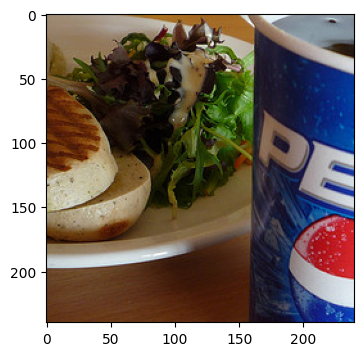

In [92]:
image = images[3, ...]
# image = image[:,:,:]
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.show()

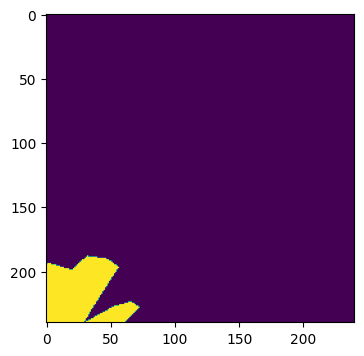

In [93]:
image = labels[2, ...]
# image = image[:,:,0]
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.show()

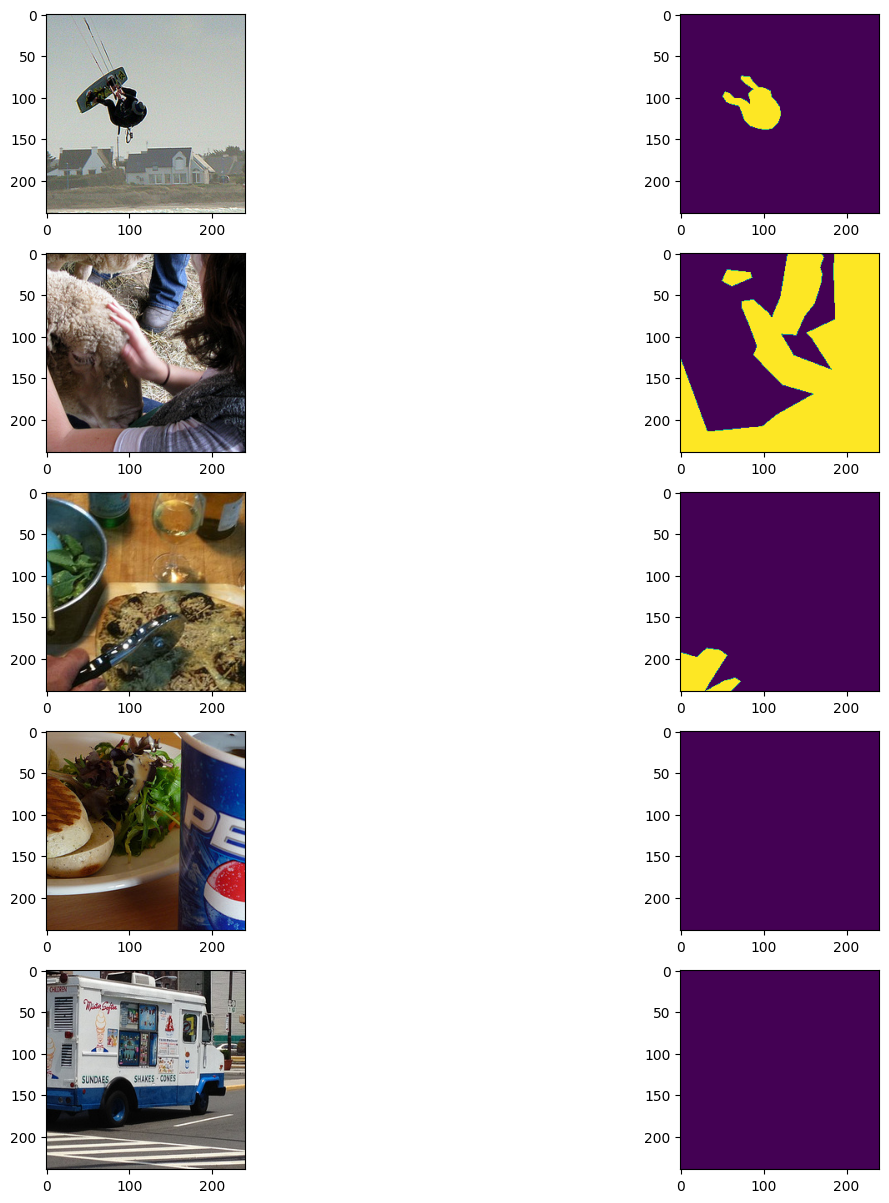

In [94]:
fig, ax = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
k = 0
for idx in range(5):
    ax[k][0].imshow(images[idx, ...], aspect=1)
    ax[k][1].imshow(labels[idx, ...], aspect=1)
    k += 1
plt.show()

In [96]:
COCO_dataset_train.img_list[1:10]

[262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230]

In [100]:
COCO_dataset_val.img_list[1:10]

[785, 872, 885, 1000, 1268, 1296, 1353, 1490, 1584]

In [102]:
len(train_ds)

10017

In [104]:
val_ds.save('val_ds_save2', compression='gzip')

In [105]:
val_ds.save('val_ds_save3', compression='GZIP')

In [ ]:
train_ds.save('train_ds_save3', compression='GZIP')